## **Modelo Supervisado (ML)**

**Tabla de contenido** 
- **Modelo Supervisado (ML)**
  - **Introducción**    
  - **Cargar datos**
  - **Visualizar los datos**
  - **Preprocesamiento**
  - **Codificar y segmentar los datos** 
  - **Entrenar modelos**
    - **Entrenar modelo con desequilibrio**    
    - **Entrenar modelo sin desequilibrio**   
    - **Escalado de Características**    
    - **Sobremuestreo**   
    - **Árbol de decisiones**    
    - **Bosque aleatorio**   
    - **Regresión logística**    
  - **Seleccionar el modelo con mayor calidad**    
  - **Mejor Modelo**
  - **Conclusiones**    

##  **Introducción**

Necesitamos predecir si un cliente dejará el banco pronto. Los datos que se utilizaran indican el el comportamiento pasado de los clientes y la terminación de contratos con el banco.

- **Objetivo:** Crer un modelo con el máximo valor F1 posible. Para aprobar la revisión, es necesario un valor F1 de al menos 0.59 y un AUC-ROC mayor de 0.70.

- **Plan de Trabajo**
    - Visualizar los datos
    - Aplicar Preprocesamiento (ausentes, duplicados, encabezados)
    - Codificar y segmentar los datos
    - Crear los modelos
        - Colocar a prueba sin revisar si hay desequilibrio en los datos
        - Verificar el desequilibrio de los datos
        - Utilizar varios modelos de clasificación
    - Seleccionar cual modelo tenga el resultado que cumpla mejor el objetivo
    - Conclusiones y recomendaciones

## **Cargar datos**

In [43]:
#Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [44]:
#Cargar archivos
try:
    df = pd.read_csv('../data/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

## **Visualizar los datos**

In [45]:
#Visualizar df
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [46]:
#Información general del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [47]:
#Tipos de datos en el df
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [48]:
#Chequeo de valores ausentes
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [49]:
#Verificar valores duplicados
df.duplicated().sum()

0

In [50]:
#Estructura en los encabezados de las columnas
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

- **Contenido**
    - `RowNumber`: índice de cadena de datos
    - `CustomerId`: identificador de cliente único
    - `Surname`: apellido
    - `CreditScore`: valor de crédito
    - `Geography`: país de residencia
    - `Gender`: sexo
    - `Age`: edad
    - `Tenure`: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
    - `Balance`: saldo de la cuenta
    - `NumOfProducts`: número de productos bancarios utilizados por el cliente
    - `HasCrCard`: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
    - `IsActiveMember`: actividad del cliente (1 - sí; 0 - no)
    - `EstimatedSalary`: salario estimado
    - `Exited`: El cliente se ha ido (1 - sí; 0 - no)

La visualización de los datos nos arroja que:
- La base de datos es de 10000 filas.
- En la columna `tenure` tiene 909 valores ausentes.
- No hay datos duplicados.
- Los encabezados de las columnas tienen mayúsculas, lo que puede dificultar la redacción de código.
- La columna objetivo es `Exited`.

## **Preprocesamiento**

In [51]:
#Arreglar el nombre de las columnas
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [52]:
#Valores de la columna con valores ausentes
df['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Por la información suministrada, los datos de la columna `tenure`, es el período durante el cual ha madurado el depósito a plazo fijo de un cliente (años). Quiere decir, que si no tenemos un valor es porque corresponde a 0 años.

In [53]:
#Reemplazar los valores ausentes por 0
df['tenure'] = df['tenure'].fillna(0)

In [54]:
#Visualizar que la columna tenure ya no tenga valores ausentes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Ya con el preprocesamiento. Los datos están listos para utilizar en los modelos.

## **Codificar y segmentar los datos**

Para colocar a prueba los datos en un modelo sin revisar el desequilibrio, se utilizara el modelo de Bosque aleatorio, por su buena adaptabilidad a los datos.

No obstante, antes de iniciar el modelado, se observó que hay columnas con datos categóricos, y que deben convertirse en numéricos. Para ello, se aplicará una codificación de etiquetas que posibilita la transformación de datos categóricos en datos numéricos y el tipo de codificación que se aplicará, será el siguiente:

- Codificación ordinal: asigna un número a cada categoría, de modo que las categorías se ordenan de manera significativa.

De esta manera, para el modelo sera mucho más optimo el entrenamiento y predicción de los datos.

In [55]:
#Codificación de etiquetas
encoder = OrdinalEncoder()

df_ord = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)

In [56]:
#Separar los datos
features = df_ord.drop(['exited'], axis = 1)
target = df_ord['exited']

#Datos de entrenamiento y validación
x_train, x_valid, y_train, y_valid = train_test_split(features, target, random_state=42, test_size = 0.25)

#Datos de testeo
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state = 42, test_size = 0.25)

In [57]:
data_uses = {
    'entrenamiento': x_train,
    'validación': x_valid,
    'testeo': x_test,
}

for key, value in data_uses.items():
    print('El tamaño de la data para el {} es de {}'.format(key, value.shape))

El tamaño de la data para el entrenamiento es de (5625, 13)
El tamaño de la data para el validación es de (2500, 13)
El tamaño de la data para el testeo es de (1875, 13)


## **Entrenar modelos**

### **Entrenar modelo con desequilibrio**

In [58]:
#Modelo prueba
rf = RandomForestClassifier(random_state=42, max_depth= 11, n_estimators= 41)

In [59]:
#Entrenar modelo
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=41, random_state=42)

In [60]:
#Predicciones del modelo
predict_valid = rf.predict(x_valid)

In [61]:
#Calculo de métricas
print('F1:',f1_score(y_valid, predict_valid))
print('Curva ROC:', roc_auc_score(y_valid, predict_valid))

F1: 0.5315436241610738
Curva ROC: 0.6867138929432812


Sin verificar el desequilibrio de las clases en el modelo, arrojo 0.7 en la curva ROC, que representa un 70% de probabilidad que el modelo pueda distinguir entre clase positiva y negativa, pero el modelo tiene un 57.4% en rendimiento del modelo. Es decir, en lineas generales el modelo puede mejorar la calidad de sus métricas y así poder cumplir con los objetivos planteados.

### **Entrenar modelo sin desequilibrio**

Se entrenaran los siguientes modelos de clasificación:
- Árbol de decisiones
- Bosque aleatorio
- Regresión logística

Antes de crear un modelo para mejorar la calidad de las métricas, es necesario aplicar un escalado de características. Este escalado se usa para cambiar los datos de manera que todas las características tengan el mismo nivel. Ahora bien, los beneficias de realizar un escalado son los siguientes:

- Puede mejorar la precisión del modelo: ayuda a los algoritmos de aprendizaje automático a aprender patrones más precisos en los datos.
- Puede mejorar la interpretabilidad del modelo: resultados más fáciles de interpretar.

### **Escalado de Características**

In [62]:
#Separar las características numéricas para aplicar el escalado
numeric = ['rownumber', 'customerid', 'creditscore',
           'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
           'isactivemember', 'estimatedsalary']

In [63]:
#Modelo a utilizar para el escalado
scaler = StandardScaler()
scaler.fit(x_train[numeric])

StandardScaler()

In [64]:
#Aplicar el solo a las características (valores x)
x_train[numeric] = scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

Por ultimo, para poder comenzar con el modelado, es necesario verificar si realmente hay desequilibrio en los datos, porque los modelos pueden aprender a centrarse en la clase mayoritaria e ignorar la clase minoritaria. Esto puede conducir a un sesgo en las predicciones de los modelos, lo que puede ser perjudicial para la toma de decisiones. Para evitar el desequilibrio, se aplicara un sobremuestreo, buscando mejorar la eficiencia de los modelos al calcular sus métricas. 

El sobremuestreo es una técnica de remuestreo que se utiliza para aumentar el número de ejemplos de una clase minoritaria en un conjunto de datos desbalanceado

### **Sobremuestreo**

In [65]:
#Verificar estatus de las clases
target.value_counts(normalize = True) * 100

0.0    79.63
1.0    20.37
Name: exited, dtype: float64

Las clases tienen una inclinación hacia los 0, bastante pronunciada, sí es necesario aplicar un sobremuestreo.

In [66]:
def upsample(x, y, repeat):
    '''
    Aplicar de forma automática el sobremuestreo de las clases
    '''
    #Dividir el conjunto de datos en notas negativas y positivas
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    #Concatenar y duplicar los datos
    x_upsampled = pd.concat([x_zeros]+ [x_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    #Mezclar los datos
    x_upsampled, y_upsampled = shuffle(x_upsampled, y_upsampled, random_state = 42)
    
    return x_upsampled, y_upsampled

In [67]:
#Aplicar la funcion de upsample
x_upsampled, y_upsampled = upsample(x_train, y_train, 5)

In [68]:
#Verificar estatus de las clases ya con el sobremuestreo aplicado
y_upsampled.value_counts(normalize = True) * 100

1.0    56.342154
0.0    43.657846
Name: exited, dtype: float64

Ya con los datos más coherentes para los modelos, los modelos que se usarán son para clasificar los puntos de datos en categorías.

### **Árbol de decisiones**

In [69]:
#Buscar los hiperparametros que arrojan las métricas con mayor calidad
best_f1_score = 0
best_depth = 0

for depth in range(1, 16):
    dtc = DecisionTreeClassifier(random_state=42, max_depth= depth, class_weight= 'balanced')
    dtc.fit(x_upsampled, y_upsampled)
    predict = dtc.predict(x_valid)
    f1 = f1_score(y_valid, predict)
    roc = roc_auc_score(y_valid, predict)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_depth = depth
        
print('f1:', best_f1_score)
print('roc:', roc)
print('max_depht:', best_depth)

f1: 0.5635792778649921
roc: 0.691711929088259
max_depht: 5


In [70]:
#Modelo
dtc = DecisionTreeClassifier(random_state=42, max_depth= best_depth, class_weight='balanced')

In [71]:
#Entrenar modelo
dtc.fit(x_upsampled, y_upsampled)
probabilities_valid = dtc.predict_proba(x_valid) #Predicciones con predict_proba para ajustar el umbral y mejorar las métricas del modelo
probabilities_one_valid = probabilities_valid[:, 1]

best_f1_dtc = 0
best_threshold_dtc = 0

#Calcular métricas
for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    roc_dtc = round(roc_auc_score(y_valid, predicted_valid),3)
    if f1 > best_f1_dtc:
        best_f1_dtc = round(f1,3)
        best_threshold_dtc = threshold

In [72]:
print('Árbol de decisiones, valor de F1:',best_f1_dtc)
print('Árbol de decisiones, valor de ROC:',roc_dtc)
print('Árbol de decisiones, umbral final:',best_threshold_dtc)

Árbol de decisiones, valor de F1: 0.563
Árbol de decisiones, valor de ROC: 0.756
Árbol de decisiones, umbral final: 0.44


### **Bosque aleatorio**

In [73]:
#Buscar los hiperparametros que arrojan las métricas con mayor calidad
best_f1_score = 0
best_est = 0
best_depth = 0

for est in range(1, 50, 10):
    for depth in range(1, 14):
        rfc= RandomForestClassifier(random_state= 42, n_estimators= est, max_depth= depth, class_weight= 'balanced')
        rfc.fit(x_upsampled, y_upsampled)
        predict = rfc.predict(x_valid)
        f1 = f1_score(y_valid, predict)
        roc = roc_auc_score(y_valid, predict)
        if f1 > best_f1_score:
            best_f1_score = f1
            best_est = est
            best_depth = depth
            best_roc = roc

In [74]:
print('F1 del mejor modelo {}'.format(best_f1_score))
print('ROC del mejor modelo {}'.format(best_roc))
print('n_estimators {}'.format(best_est))
print('max_depht {}'.format(best_depth))

F1 del mejor modelo 0.6111111111111112
ROC del mejor modelo 0.7591851659131021
n_estimators 41
max_depht 12


In [75]:
#Modelo
rfc = RandomForestClassifier(random_state= 42, max_depth= best_depth, n_estimators= best_est, class_weight= 'balanced')

In [76]:
#Entrenar modelo
rfc.fit(x_upsampled, y_upsampled)
probabilities_valid = rfc.predict_proba(x_valid) #Predicciones con predict_proba para ajustar el umbral y mejorar las métricas del modelo
probabilities_one_valid = probabilities_valid[:, 1]

best_f1_rfc = 0

#Calcular métricas
for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    roc_rfc = round(roc_auc_score(y_valid, predicted_valid),3)
    if f1 > best_f1_rfc:
        best_f1_rfc = round(f1,3)
        best_threshold_rfc = threshold

In [77]:
print('Bosque aleatorio, valor de F1:',best_f1_rfc)
print('Bosque aleatorio, valor de ROC:',roc_rfc)
print('Bosque aleatorio, umbral final:',best_threshold_rfc)

Bosque aleatorio, valor de F1: 0.601
Bosque aleatorio, valor de ROC: 0.759
Bosque aleatorio, umbral final: 0.44


### **Regresión logística**

In [78]:
#Modelo
lr= LogisticRegression(random_state=12345, solver='liblinear')


In [79]:
#Entrenar modelo
lr.fit(x_upsampled, y_upsampled)
probabilities_valid = lr.predict_proba(x_valid) #Predicciones con predict_proba para ajustar el umbral y mejorar las métricas del modelo
probabilities_one_valid = probabilities_valid[:, 1]

best_f1_lr = 0

#Calcular métricas
for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(y_valid, predicted_valid)
    roc_lr = round(roc_auc_score(y_valid, predicted_valid),3)
    if f1 > best_f1_lr:
        best_f1_lr = round(f1,3)
        best_threshold_lr = threshold

In [80]:
print('Regresión logística, valor de F1:',best_f1_lr)
print('Regresión logística, valor de ROC:',roc_lr)
print('Regresión logística, umbral final:',best_threshold_lr)

Regresión logística, valor de F1: 0.441
Regresión logística, valor de ROC: 0.672
Regresión logística, umbral final: 0.48


## **Seleccionar el modelo con mayor calidad**

In [81]:
models = pd.DataFrame(
    {
        'models' : ['DecisionTreeClassifier' ,'RandomForestClassifier', 'LogisticRegression'],
        'f1' : [best_f1_dtc, best_f1_rfc, best_f1_lr],
        'roc' : [roc_dtc, roc_rfc, roc_lr]
    }
)
models = models.sort_values('f1', ascending= False)
models

,models,f1,roc
1,RandomForestClassifier,0.601,0.759
0,DecisionTreeClassifier,0.563,0.756
2,LogisticRegression,0.441,0.672


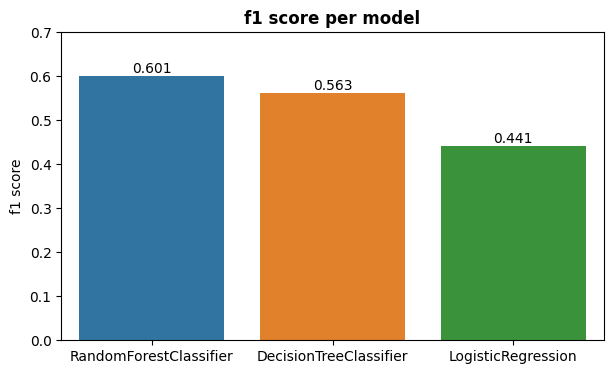

In [82]:
fig = plt.figure(figsize=(7, 4))
ax = sns.barplot(
    data = models,
    x = 'models',
    y = 'f1',
    ax=fig.add_subplot(),
    )
plt.bar_label(ax.containers[0], fmt='%.3f')
plt.title('f1 score per model', fontweight = 'bold')
plt.ylim(0, 0.7)
plt.ylabel('f1 score')
plt.xlabel('')
plt.show()

El modelo con mejor calidad en las métricas y que cumple con los objetivos establecidos es el Bosque aleatorio con un score de f1 0.601 y roc de 0.759.

Ya teniendo el mejor modelo, se aplicará con los datos de testeo para evaluar la calidad de sus métricas y si cumple con los objetivos planteados.

## **Mejor Modelo**

In [83]:
#Mejor modelo
rfc = RandomForestClassifier(random_state= 42, max_depth= 12, n_estimators= 41, class_weight= 'balanced')

rfc.fit(x_upsampled, y_upsampled)
probabilities_test = rfc.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]

best_f1_rfc = 0

#Calcular métricas
for threshold in np.arange(0.0, 0.5, 0.02):
    predicted_test = probabilities_one_test > threshold
    f1 = round(f1_score(y_test, predicted_test),3)
    roc_rfc = round(roc_auc_score(y_test, predicted_test),3)
    r = round(recall_score(y_test, predicted_test),3)
    p = round(precision_score(y_test, predicted_test),3)
    if f1 > best_f1_rfc:
        best_f1_rfc = f1
        best_roc_rfc = roc_rfc
        best_threshold_rfc = threshold
        best_r = r
        best_p = p

In [84]:
print('Bosque aleatorio, valor de F1:',best_f1_rfc)
print('Bosque aleatorio, valor de ROC:',best_roc_rfc)
print('Bosque aleatorio, valor de Recall:',best_r)
print('Bosque aleatorio, valor de Precision:',best_p)
print('Bosque aleatorio, umbral final:',best_threshold_rfc)

Bosque aleatorio, valor de F1: 0.606
Bosque aleatorio, valor de ROC: 0.758
Bosque aleatorio, valor de Recall: 0.635
Bosque aleatorio, valor de Precision: 0.579
Bosque aleatorio, umbral final: 0.48


## **Conclusiones**

1. **Visualización:** Una base de datos con un tamaño de 10000 filas, donde solo en la columna `tenure` habían 91 valores ausentes, no hay daos duplicados y los encabezados tienen letras mayúsculas.

2. **Preprocesamiento:** Se reemplazaron los valores ausentes en la columna `tenure` con 0 años, los encabezados con mayúsculas fueron convertidos a minúsculas para facilitar la redacción en el código.

3. **Codificación y segmentación:** en la codificación para mejorar la lectura de los modelos se utilizo una codificación ordinal y para la segmentación los datos fueron separados en 75% para el entrenamiento y 25% para la validación.

4. **Modelado:** En el modelado de prueba se utilizo un bosque aleatorio por su gran capacidad para adaptarse a los datos y sin emplear enfoques para mejorar el desequilibrio de los valores. Los resultados de las métricas fueron los siguientes:

| Modelo | F1 | ROC |
|---|---|---|
| Bosque aleatorio | 0.531 | 0.686 |

Ahora bien, se midieron tres modelos:
- Árbol de decisiones
- Bosque aleatorio
- Regresión logística

Y para mejorar la calidad de las métricas, se utilizaron tres enfoques:
- Escalado de características: se utilizo un escalado estándar que se enfoca en mejorar la eficiencia del aprendizaje y hacer que los datos sean más comparables.

- Sobremuestreo: Se aplico, debido que las clases estaban desequilibradas hacia la clase 0 con un 79.63% y la clase 1 con 20.37%, el sobremuestreo se enfoca en evitar el sesgo y aumentar la generalización. Luego de aplicado, las clases se equilibraron en 56.36% la clase 1 y 43.63% la 0.

- Disminución del umbral: El objetivo del modelo es predecir que clientes tienen mayor probabilidad de retirarse del banco. En este caso, se trata de un modelo de clasificación binaria, eso quiere decir que tener una precisión alta no es un beneficio para el modelo, puesto que se aumentarían los falsos negativos y seguirían dejando el banco los clientes sin contactar con ellos. En cambio, disminuir el umbral ayuda a que el modelo se centre en los clientes que tienen mayor probabilidad de retirarse del banco, incluso si esto significa que se contactarán a algunos clientes que no tienen la intención de retirarse y eso puede impulsar aun más su estadía. El umbral se disminuyo a 0.45 en todos los modelos.

Ya aplicando los tres enfoques y realizando el calculo con todos los modelos, los resultados arrojados fueron los siguientes:

| Modelos | F1 | ROC |
|---|---|---|
| **Bosque aleatorio** | **0.601** | **0.759** |
| Árbol de decisiones | 0.563 | 0.756 |
| Regresión logística | 0.441 | 0.672 |

5. **Conclusión final:** El modelo más eficiente para predecir si un cliente dejará el banco y que cumple con los objetivos, es decir, un resultado en las métricas de f1 mayor o igual a 0.59 y un resultado mayor a 0.70 en la curva ROC, es el modelo de **bosque aleatorio** con un score en f1 de 0.60 y 0.75 en la curva ROC. El resultado de f1 indica el equilibrio entre la precision y recall, teniendo un 60.6% de ambas métricas y el valor de la curva ROC indica que el modelo es capaz de distinguir entre instancias positivas e instancias negativas con un buen grado de precisión de 75.8%.